In [1]:
import sys, os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import random
from iowa_env import Iowa_Gambling_Task
from IPython.display import clear_output
from pandas import DataFrame

In [2]:
class VSQagent: ## define VS Q learning agent
    def __init__(self, pos_learning_rate, neg_learning_rate, beta, gamma, get_legal_actions, q_weight = 0.5):
        self.get_legal_actions = get_legal_actions
        self.pos_qvalues  = defaultdict(lambda: defaultdict(lambda: 0.0))
        self.neg_qvalues  = defaultdict(lambda: defaultdict(lambda: 0.0))
        self.pos_learning_rate = pos_learning_rate
        self.neg_learning_rate = neg_learning_rate
        self.beta = beta
        self.gamma = gamma
        self.q_weight = 0.5 ##1에 가까울 수록 긍정적 보상에 비중을 더 줌. 반대로 0에 가까울 수록 부정적 보상에 비중을 더 줌. 

    def get_qvalue(self, state, action):
        return self.q_weight * self.pos_qvalues[state][action]-(1-self.q_weight)*self.neg_qvalues[state][action]

    def get_pos_q_value(self, state):
        ## state에 대한 pos_q_value return 하기
        #V(s) = max_a Q(state,action) 이용하기 
        possible_actions = self.get_legal_actions(state) ## 가능한 action 가져오기
        if not possible_actions:
            return 0.0
        # Ensure qvalues are floats for max comparison
        pos_q_values = [] ## q_value를 보관할 리스트
        for action in possible_actions: ## 가능한 행동의 q_value들을 리스트에 삽입하기
          pos_q_values.append(self.pos_qvalues[state][action])
        value = max(pos_q_values) ## 가장 높은 q_value 찾기
        return value

    def get_neg_q_value(self, state):
        ## state에 대한 neg_q_value return 하기
        #V(s) = max_a Q(state,action) 이용하기 
        possible_actions = self.get_legal_actions(state) ## 가능한 action 가져오기
        if not possible_actions:
            return 0.0
        # Ensure qvalues are floats for max comparison
        neg_q_values = [] ## q_value를 보관할 리스트
        for action in possible_actions: ## 가능한 행동의 q_value들을 리스트에 삽입하기
          neg_q_values.append(self.neg_qvalues[state][action])
        value = max(neg_q_values) ## 가장 높은 q_value 찾기
        return value
        
        
    def update(self, state, action, pos_r, neg_r, next_state):
        # Q(s,a) += learning_rate * (r + gamma * V(s') - Q(s,a))
        gamma = self.gamma
        pos_learning_rate = self.pos_learning_rate
        neg_learning_rate = self.neg_learning_rate

        # 현재 state, action q value
        pos_q = self.pos_qvalues[state][action]
        neg_q = self.neg_qvalues[state][action]

        ## next state q value
        next_pos_q = self.get_pos_q_value(next_state)
        next_neg_q = self.get_neg_q_value(next_state)

        ## update
        self.pos_qvalues[state][action] += pos_learning_rate * (pos_r+gamma*next_pos_q - pos_q)
        self.neg_qvalues[state][action] += neg_learning_rate * (neg_r+gamma*next_neg_q - neg_q)
        

    def softmax(self, q_values):
        q_values = np.array(q_values) ## q_values를 np.array로 변환
        nor_q_values = q_values-np.max(q_values)
        beta_q_values = self.beta * nor_q_values ## beta 곱하기
        exp_q_values  = np.exp(beta_q_values) ## exp
        probs = exp_q_values/np.sum(exp_q_values) ## 밑 나누기
        return probs 


    def get_action(self, state): 
        possible_actions = self.get_legal_actions(state) ## 가능한 행동 가져오기
        if not possible_actions:
            return None

        q_values = []
        for action in possible_actions: 
            q_values.append(self.get_qvalue(state,action))
        probs = self.softmax(q_values)
        chosen_action = np.random.choice(possible_actions, p=probs)
        return chosen_action   


In [7]:
def play_and_train(env, agent, t_max=10**2): ## 한 번의 에피소드를 돌리는 것임.
    """ Runs one episode, trains the agent, returns total reward. """
    total_reward = 0.0
    pos_q_values, neg_q_values = [], [] ## positive q_value, negative q_value
    s, info = env.reset() # Use gymnasium reset signature

    for t in range(t_max):
        a = agent.get_action(s)
        if a is None: # Handle cases where no actions are possible (shouldn't happen in these envs)
             break
        
        # Use gymnasium step signature
        next_s, r, terminated, info = env.step(a)

        pos_q_values.append([agent.pos_qvalues[s][0], agent.pos_qvalues[s][1], agent.pos_qvalues[s][2], agent.pos_qvalues[s][3]]) 
        neg_q_values.append([agent.neg_qvalues[s][0], agent.neg_qvalues[s][1], agent.neg_qvalues[s][2], agent.neg_qvalues[s][3]])

        pos_r , neg_r = info["positive_reward"], info["negative_reward"]

        # Train the agent
        agent.update(s, a, pos_r, neg_r, next_s)

        s = next_s
        total_reward += r
        if terminated : # Use gymnasium termination flags
            break


    return total_reward, pos_q_values, neg_q_values

mean reward = 2535.0


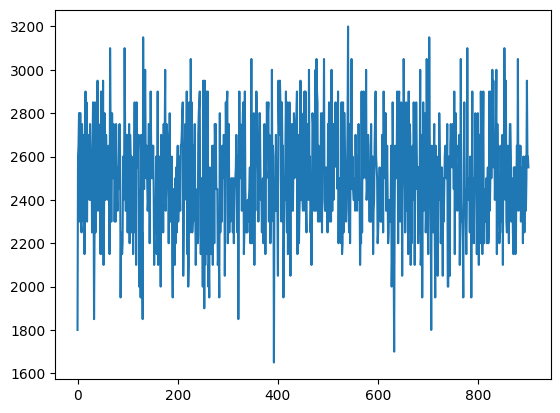

In [17]:
env = Iowa_Gambling_Task()
n_actions = env.action_space.n
env.reset()

## agent 정의
agent = VSQagent(pos_learning_rate=0.1, neg_learning_rate=0.1, beta= 0.1, gamma=0.99,
                       get_legal_actions=lambda s: range(n_actions), q_weight = 0.5)

rewards = []
many_trial_pos_q_values = []
many_trial_neg_q_values = []
for i in range(1000):
    reward, pos_q_values, neg_q_values = play_and_train(env, agent)
    rewards.append(reward)
    many_trial_pos_q_values.extend(pos_q_values)
    many_trial_neg_q_values.extend(neg_q_values)

    if i % 100 == 0:
        clear_output(True)
        print('mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

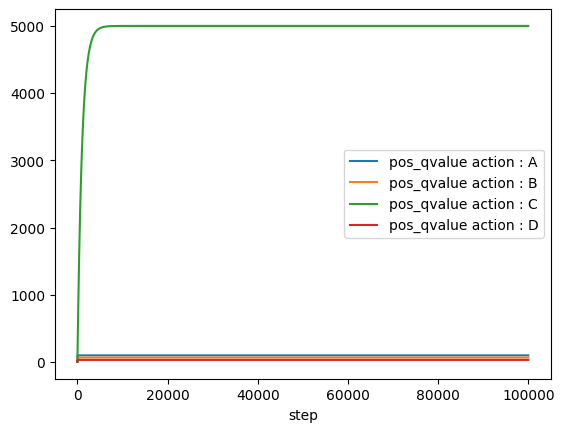

In [23]:
## 전체적인 postive figure
arr_pos_q_values = np.array(many_trial_pos_q_values)
for action in range(4):
    plt.plot(arr_pos_q_values[:, action], label = f"pos_qvalue action : {chr(action+65)}")
plt.legend()
plt.xlabel("step")
plt.show()

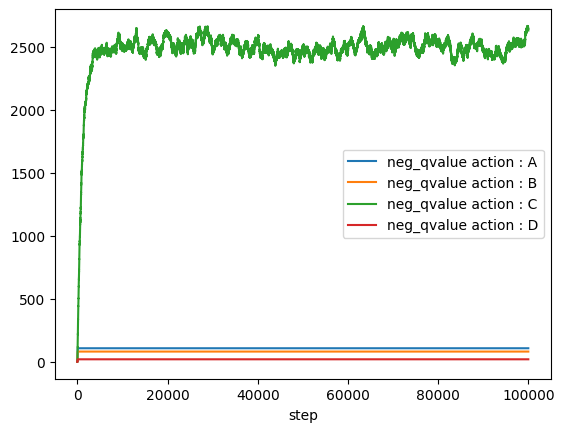

In [24]:
## 전체적인 negative figure
arr_neg_q_values = np.array(many_trial_neg_q_values)

for action in range(4):
    plt.plot(arr_neg_q_values[:, action], label = f"neg_qvalue action : {chr(action+65)}")

plt.legend()
plt.xlabel("step")
plt.show()

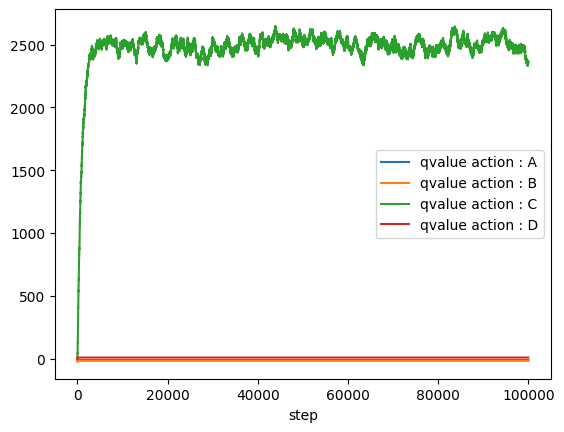

In [26]:
## 두 개를 결합한 거 ## 비율 1:1

## 전체적인 postive figure
temp = arr_pos_q_values-arr_neg_q_values
for action in range(4):
    plt.plot(temp[:, action], label = f"qvalue action : {chr(action+65)}")
plt.legend()
plt.xlabel("step")
plt.show()